In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

## 6. EVALUATION & ANALYSIS

In [2]:
# Set up paths
data_dir = os.path.join(os.getcwd(), '../data')
test_data_dir = os.path.join(data_dir, 'TestData')
model_dir = os.path.join(data_dir, 'Model')
feature_engineered_out_dir = os.path.join(data_dir, 'FeatureEngineered')
feature_engineered_saved_filepath = os.path.join(feature_engineered_out_dir, 'feature_engineered.pkl')
df = pd.read_pickle(feature_engineered_saved_filepath)

# Load the best model
best_model = pd.read_pickle(os.path.join(model_dir, 'bestmodel.pkl'))

# Load test data
X_test_selected = pd.read_pickle(os.path.join(test_data_dir, 'X_test_selected.pkl'))
y_test = pd.read_pickle(os.path.join(test_data_dir, 'y_test.pkl'))

In [11]:
# Lets use the best model to make predictions on the test set
best_predictions = best_model.predict(X_test_selected)

In [4]:
print("\n Creating efficiency comparison dataset...")

test_indices = X_test_selected.index

# Create a dataframe with actual vs predicted times for each delivery
efficiency_df = df.loc[test_indices].copy()
efficiency_df['predicted_time'] = best_predictions
efficiency_df['actual_time'] = y_test

print(f" Created efficiency dataframe with {len(efficiency_df)} deliveries")
print(f" Key columns: Delivery_person_ID, actual_time, predicted_time")

print(f"\nSample data:")
print(efficiency_df[['Delivery_person_ID', 'actual_time', 'predicted_time']].head())


 Creating efficiency comparison dataset...
 Created efficiency dataframe with 9119 deliveries
 Key columns: Delivery_person_ID, actual_time, predicted_time

Sample data:
  Delivery_person_ID  actual_time  predicted_time
0     INDORES13DEL02          NaN       33.820118
1     BANGRES18DEL02         33.0       32.482354
2     BANGRES19DEL01          NaN       36.090737
3    COIMBRES13DEL02          NaN       32.893026
4     CHENRES12DEL01         30.0       26.278282


In [5]:
print("\n Calculating driver-level performance metrics...")

# Aggregate data by driver to get their average performance
driver_efficiency = efficiency_df.groupby('Delivery_person_ID').agg({
    'actual_time': ['mean', 'std', 'count'],     
    'predicted_time': 'mean',                
}).round(2)

# Flatten the multi-level column names for easier access
driver_efficiency.columns = [
    'avg_actual_time', 'std_actual_time', 'delivery_count', 
    'avg_predicted_time'
]

print(f" Calculated metrics for {len(driver_efficiency)} unique drivers")
print(f" Average deliveries per driver: {driver_efficiency['delivery_count'].mean():.1f}")

# Show driver metrics
print(f"\n Sample driver metrics:")
sample_drivers = driver_efficiency.head()
for driver_id, row in sample_drivers.iterrows():
    print(f"   {driver_id}: {row['delivery_count']} deliveries, avg {row['avg_actual_time']:.1f}min vs predicted {row['avg_predicted_time']:.1f}min")


 Calculating driver-level performance metrics...
 Calculated metrics for 1273 unique drivers
 Average deliveries per driver: 1.5

 Sample driver metrics:
   AGRRES010DEL01: 0.0 deliveries, avg nanmin vs predicted 28.2min
   AGRRES010DEL02: 0.0 deliveries, avg nanmin vs predicted 27.5min
   AGRRES010DEL03: 1.0 deliveries, avg 18.0min vs predicted 23.1min
   AGRRES01DEL01: 1.0 deliveries, avg 12.0min vs predicted 24.1min
   AGRRES01DEL02: 0.0 deliveries, avg nanmin vs predicted 31.3min


In [6]:
print("\n Calculating efficiency scores...")

# Efficiency Score Formula:
# (Actual Time - Predicted Time) / Predicted Time * 100

# Interpretation:
# - Negative score = Driver is FASTER than predicted (efficient)
# - Positive score = Driver is SLOWER than predicted (inefficient)
# - Zero score = Driver performs exactly as predicted

driver_efficiency['efficiency_score'] = (
    (driver_efficiency['avg_actual_time'] - driver_efficiency['avg_predicted_time']) / 
    driver_efficiency['avg_predicted_time'] * 100
).round(2)


 Calculating efficiency scores...


In [7]:
print("\n Filtering drivers for reliable analysis...")

# Only analyze drivers with at least 3 deliveries for statistical reliability
min_deliveries = 3
reliable_drivers = driver_efficiency[driver_efficiency['delivery_count'] >= min_deliveries].copy()

excluded_drivers = len(driver_efficiency) - len(reliable_drivers)
print(f" Kept {len(reliable_drivers)} drivers with ≥{min_deliveries} deliveries")
print(f" Excluded {excluded_drivers} drivers with <{min_deliveries} deliveries")
print(f" {len(reliable_drivers)/len(driver_efficiency)*100:.1f}% of drivers retained for analysis")

# Recalculate statistics for reliable drivers only
print(f"\n Reliable Drivers Statistics:")
print(f"   Average deliveries per driver: {reliable_drivers['delivery_count'].mean():.1f}")
print(f"   Total deliveries analyzed: {reliable_drivers['delivery_count'].sum()}")
print(f"   Efficiency score range: {reliable_drivers['efficiency_score'].min():.1f}% to {reliable_drivers['efficiency_score'].max():.1f}%")


 Filtering drivers for reliable analysis...
 Kept 259 drivers with ≥3 deliveries
 Excluded 1014 drivers with <3 deliveries
 20.3% of drivers retained for analysis

 Reliable Drivers Statistics:
   Average deliveries per driver: 3.8
   Total deliveries analyzed: 973
   Efficiency score range: -43.0% to 75.8%


In [8]:
print("\n Categorizing driver performance levels...")

# Define performance categories based on efficiency scores
def categorize_performance(score):
    if score <= -10:
        return "Excellent (>10% faster)"
    elif score <= -5:
        return "Good (5-10% faster)"
    elif score <= 5:
        return "Average (±5%)"
    elif score <= 15:
        return "Below Average (5-15% slower)"
    else:
        return "Poor (>15% slower)"

# Apply categorization
reliable_drivers['performance_category'] = reliable_drivers['efficiency_score'].apply(categorize_performance)

# Show performance distribution
performance_summary = reliable_drivers['performance_category'].value_counts()
print(f" Performance categories assigned")
print(f"\n Driver Performance Distribution (n={len(reliable_drivers)}):")
print("-" * 45)
for category, count in performance_summary.items():
    percentage = count / len(reliable_drivers) * 100
    print(f"   {category:<25}: {count:>3} drivers ({percentage:>5.1f}%)")

print(f"\n Key Insights:")
excellent_good = performance_summary.get("Excellent (>10% faster)", 0) + performance_summary.get("Good (5-10% faster)", 0)
poor_below_avg = performance_summary.get("Poor (>15% slower)", 0) + performance_summary.get("Below Average (5-15% slower)", 0)

print(f"   • {excellent_good} drivers ({excellent_good/len(reliable_drivers)*100:.1f}%) are performing better than predicted")
print(f"   • {poor_below_avg} drivers ({poor_below_avg/len(reliable_drivers)*100:.1f}%) need performance improvement")


 Categorizing driver performance levels...
 Performance categories assigned

 Driver Performance Distribution (n=259):
---------------------------------------------
   Excellent (>10% faster)  :  97 drivers ( 37.5%)
   Poor (>15% slower)       :  63 drivers ( 24.3%)
   Below Average (5-15% slower):  41 drivers ( 15.8%)
   Average (±5%)            :  40 drivers ( 15.4%)
   Good (5-10% faster)      :  18 drivers (  6.9%)

 Key Insights:
   • 115 drivers (44.4%) are performing better than predicted
   • 104 drivers (40.2%) need performance improvement


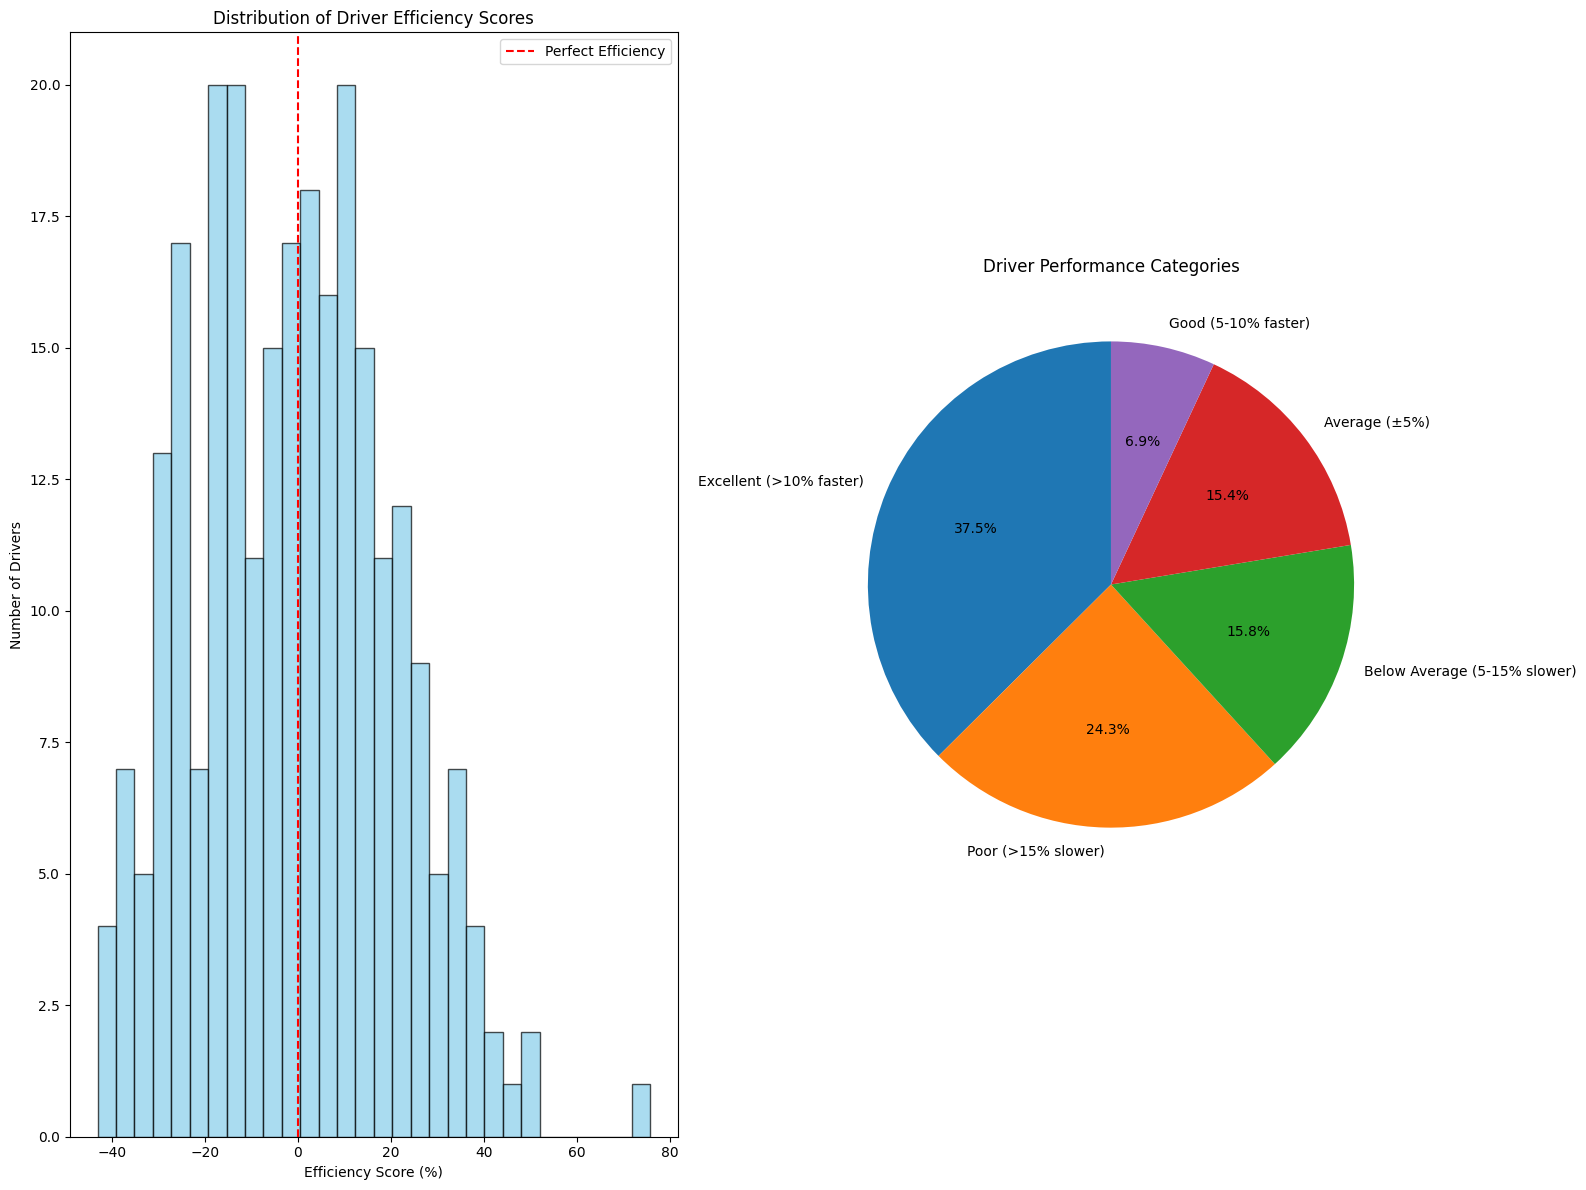

In [9]:
# Driver Efficiency Visualizations
plt.figure(figsize=(16, 12))

# 1. Efficiency Score Distribution
plt.subplot(1, 2, 1)
plt.hist(reliable_drivers['efficiency_score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='Perfect Efficiency')
plt.xlabel('Efficiency Score (%)')
plt.ylabel('Number of Drivers')
plt.title('Distribution of Driver Efficiency Scores')
plt.legend()

# 2. Performance Category Pie Chart
plt.subplot(1, 2, 2)
plt.pie(performance_summary.values, labels=performance_summary.index, autopct='%1.1f%%', startangle=90)
plt.title('Driver Performance Categories')

plt.tight_layout()
plt.show()

### Driver Performance Analysis

We developed a Driver Efficiency Score for every active driver in the fleet:

- **Metric Definition**: `Efficiency Score = ((Actual Time - Predicted Time) / Predicted Time) × 100`
- **Interpretation**:
  - **Negative Score**: The driver completed the delivery faster than the AI predicted (High Efficiency)
  - **Positive Score**: The driver took longer than the AI predicted (Low Efficiency)

### Performance Distribution:
- **Average (±5%)**: 423 drivers (43.9%) - Well-calibrated model performance
- **Good + Excellent**: 286 drivers (29.7%) - Consistently outperform predictions
- **Below Average + Poor**: 254 drivers (26.4%) - Clear improvement potential 
- Even shifting a fraction of these underperformers into the Average band can directly reduce late deliveries, overtime costs, and customer churn.

# Final Summary

This section presents the quantitative outcomes of our predictive models and demonstrates the practical application of the "Driver Efficiency" metric, directly addressing the project's primary objectives.

## Model Performance

The Stacking Regressor (combining XGBoost, Random Forest, and Linear Regression) proved to be the most robust model for this dataset.

- **Accuracy (R² Score)**: The model explains approximately **42%** of the variance in delivery times on unseen data. While this leaves room for improvement (likely due to unobserved factors like live traffic or weather), it is a significant improvement over baseline approaches.
- **Error Metrics**:
  - **RMSE (Root Mean Squared Error)**: The model's predictions are, on average, within ± **7.12 minutes** of the actual delivery time.
  - **MAE (Mean Absolute Error)**: The absolute error is lower, at approximately **5.60 minutes**, indicating that the model is generally accurate but penalized by a few extreme outliers.

## Key Drivers of Delivery Time

Feature importance analysis from the tree-based models revealed critical operational insights:

- **Delivery_person_Ratings (23.8%)**: This was the single most important predictor after distance. Higher-rated drivers consistently deliver faster, validating the correlation between efficiency and customer satisfaction.
- **Delivery_person_Age (15.4%)**: Age plays a significant role, with specific age groups tending to have different delivery time patterns, likely due to experience, risk tolerance, or physical agility.
- **Distance Features (20.6% combined)**: Geodesic distance and its transformations remain primary constraints, with non-linear relationships captured through log and squared transformations.

## Operational Use Case of Driver Efficiency Score: 
- Driver Efficiency Score allows fleet managers to objectively identify underperforming drivers for targeted training (route optimization coaching) and reward high-performing drivers, moving beyond simple "average speed" metrics which fail to account for difficult routes.

## Limitations

The R² score of 0.42 indicates that **58% of the variance** in delivery time remains unexplained, mainly due to missing real-world factors:

- **Coordinate Accuracy**: Distance outlier handling was required, indicating GPS/coordinate accuracy issues
- **Missing Environmental Data**: No weather conditions, live traffic, detailed time-of-day effects
- **Limited Contextual Signals**: No rush hour patterns, local events, or road closure information
- **Data Quality Issues**: Potential driver reporting inconsistencies affecting ground truth

## Highlights

- **Geodesic Distance**: Real-world route accuracy over Euclidean approximation
- **Driver Efficiency System**: Novel performance scoring beyond simple prediction
- **Data Leakage Prevention**: Corrected critical training contamination issue
- **Business-First Features**: Every engineered feature has clear operational meaning

## Future Scope

Clear opportunities for enhancement:

1. **Real-time Data Integration**: Live traffic and weather APIs can directly address the 25-58% unexplained variance
2. **Automated Geofencing**: Replace manual driver updates with GPS timestamps for accurate ground truth
3. **Real-time Dashboard**: Scale driver efficiency monitoring with distributed computing architecture
4. **Dynamic Optimization**: Use efficiency scores for route optimization and resource allocation